In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
random_state = 20
threshold = 2

In [4]:
df = pd.read_csv("test_data/S Parameter Plot 2.csv")

In [5]:
df

,Pad_L [cm],Pad_W [cm],Freq [GHz],"dB(S(1,1)) []"
0,0.35,0.4,2.00,-0.039230
1,0.35,0.4,2.18,-0.053142
2,0.35,0.4,2.36,-0.067467
3,0.35,0.4,2.54,-0.082482
4,0.35,0.4,2.72,-0.098518
...,...,...,...,...
904,0.45,0.8,19.28,-5.728851
905,0.45,0.8,19.46,-6.172101
906,0.45,0.8,19.64,-7.396826
907,0.45,0.8,19.82,-7.555971


<Axes: xlabel='Freq [GHz]'>

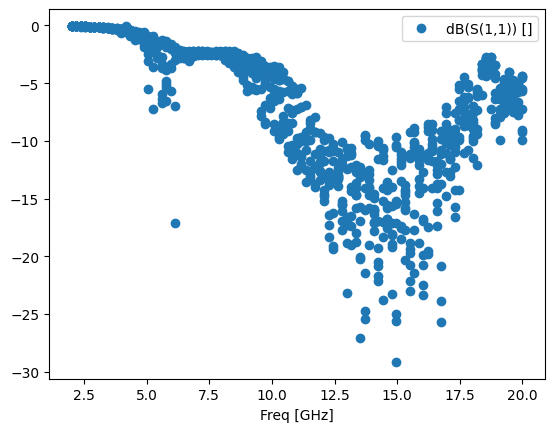

In [6]:
df.plot(x=df.columns[2], y=df.columns[3], style='o')

In [7]:
input_x = df[['Pad_L [cm]', 'Pad_W [cm]', 'Freq [GHz]']]
input_y = df[['dB(S(1,1)) []']]

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(input_x, input_y, random_state=random_state)

In [10]:
model = DecisionTreeRegressor(random_state=random_state)

In [11]:
pipeline = Pipeline(steps=[('normalize', scaler), ('model', model)])

In [12]:
pipeline_fit = pipeline.fit(X_train, y_train)
predictions = pipeline_fit.predict(X_test)


In [13]:
results = X_test.copy()

In [14]:
# Check if predicted value is threshold amount above or below actual value
def is_in_threshold(actual, pred):
    return pred <= actual + threshold and pred >= actual - threshold

In [15]:
def create_tf_column(results):
    return results.apply(lambda x: is_in_threshold(x['y_test'], x['predictions']), axis=1)

In [16]:
def get_score(X_test, y_test, predictions, clf_dt):
    predictions = clf_dt.predict(X_test)
    dataframe = pd.DataFrame(X_test.copy(), columns=input_x.columns)
    dataframe['y_test'] = y_test.values
    dataframe['predictions'] = predictions
    return create_tf_column(dataframe).value_counts().get(True) / dataframe.shape[0]

In [45]:
X_test

,Pad_L [cm],Pad_W [cm],Freq [GHz]
376,0.35,0.6,15.14
798,0.40,0.8,18.38
783,0.40,0.8,15.68
120,0.40,0.4,5.42
580,0.45,0.6,15.50
...,...,...,...
171,0.40,0.4,14.60
45,0.35,0.4,10.10
57,0.35,0.4,12.26
140,0.40,0.4,9.02


In [17]:
get_score(X_test, y_test, predictions, pipeline)

0.8377192982456141

In [18]:

path = model.cost_complexity_pruning_path(X_train, y_train)

In [19]:
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

In [20]:
clf_dts = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeRegressor(random_state=random_state, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

In [21]:
# train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [get_score(X_test, y_test, predictions, clf_dt) for clf_dt in clf_dts]

In [22]:
test_scores

[0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280701754,
 0.8464912280

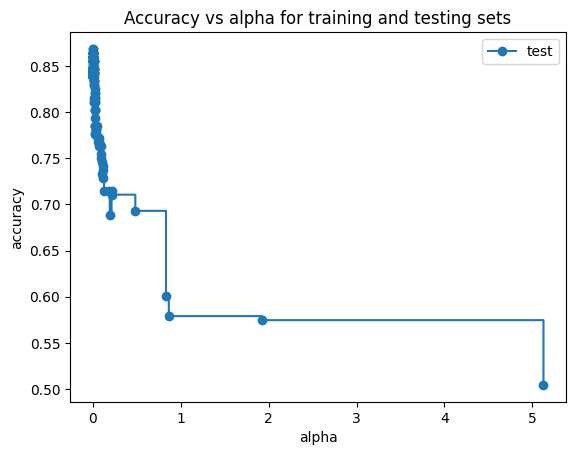

In [23]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
# ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()


In [24]:
from sklearn.model_selection import GridSearchCV
import joblib

In [39]:
param_grid_tree = [{
    'model__ccp_alpha': np.arange(0,2,0.1),
    'model__max_depth': [1,3,5,7,9,11,12],
    'model__min_samples_split': [2, 3, 4],
    "model__min_samples_leaf":[1,2,3],
    # "model__min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
    # "model__max_features":["auto","log2","sqrt",None],
    # "model__max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90],
    # 'model__splitter': ['best', 'random']
}]



In [40]:
GridSearchCV_tree = GridSearchCV(estimator=pipeline,
                                 param_grid=param_grid_tree, cv=2, verbose=2)


In [41]:


gscv = GridSearchCV_tree.fit(input_x, input_y)


Fitting 2 folds for each of 1260 candidates, totalling 2520 fits
[CV] END model__ccp_alpha=0.0, model__max_depth=1, model__min_samples_leaf=1, model__min_samples_split=2; total time=   0.0s
[CV] END model__ccp_alpha=0.0, model__max_depth=1, model__min_samples_leaf=1, model__min_samples_split=2; total time=   0.0s
[CV] END model__ccp_alpha=0.0, model__max_depth=1, model__min_samples_leaf=1, model__min_samples_split=3; total time=   0.0s
[CV] END model__ccp_alpha=0.0, model__max_depth=1, model__min_samples_leaf=1, model__min_samples_split=3; total time=   0.0s
[CV] END model__ccp_alpha=0.0, model__max_depth=1, model__min_samples_leaf=1, model__min_samples_split=4; total time=   0.0s
[CV] END model__ccp_alpha=0.0, model__max_depth=1, model__min_samples_leaf=1, model__min_samples_split=4; total time=   0.0s
[CV] END model__ccp_alpha=0.0, model__max_depth=1, model__min_samples_leaf=2, model__min_samples_split=2; total time=   0.0s
[CV] END model__ccp_alpha=0.0, model__max_depth=1, model__mi

In [42]:
gscv.best_estimator_.get_params()

{'memory': None,
 'steps': [('normalize', MinMaxScaler()),
  ('model', DecisionTreeRegressor(max_depth=12, random_state=20))],
 'verbose': False,
 'normalize': MinMaxScaler(),
 'model': DecisionTreeRegressor(max_depth=12, random_state=20),
 'normalize__clip': False,
 'normalize__copy': True,
 'normalize__feature_range': (0, 1),
 'model__ccp_alpha': 0.0,
 'model__criterion': 'squared_error',
 'model__max_depth': 12,
 'model__max_features': None,
 'model__max_leaf_nodes': None,
 'model__min_impurity_decrease': 0.0,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__min_weight_fraction_leaf': 0.0,
 'model__random_state': 20,
 'model__splitter': 'best'}

In [44]:
joblib.dump(gscv.best_estimator_, "antenna_model.pkl", compress=1)

['antenna_model.pkl']